In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
raw_df = pd.read_csv('data/housing.csv')
raw_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


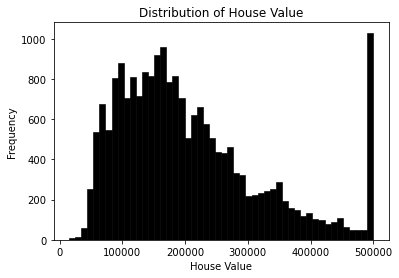

In [3]:
plt.figure(figsize=(6, 4))

sns.histplot(raw_df.median_house_value, bins=50, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('House Value')
plt.title('Distribution of House Value')

plt.show()

### Main Dataframe

In [4]:
feats = ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
df = raw_df[feats]
df

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,37.88,-122.23,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,37.86,-122.22,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,37.85,-122.24,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,37.85,-122.25,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,37.85,-122.25,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0
...,...,...,...,...,...,...,...,...,...
20635,39.48,-121.09,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0
20636,39.49,-121.21,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0
20637,39.43,-121.22,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0
20638,39.43,-121.32,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0


### Question 1
#### Find a feature with missing values. How many missing values does it have?

In [5]:
# Total bedrooms with 207 missing values
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

### Question 2

#### What's the median (50% percentile) for variable 'population'?

In [6]:
# Median (also get using 'df.population.quantile(0.5)') is 1166.0
df.population.median()

1166.0

In [7]:
def split_data(df: pd.DataFrame, dist: list=[.6, .2, .2], seed: int=42) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    total = int(len(df))
    n_val = int(total * dist[1])
    n_test = int(total * dist[2])
    n_train = int(total - (n_val + n_test))
    idx = np.arange(total)
    np.random.seed(seed)
    np.random.shuffle(idx)
    train = df.iloc[idx[:n_train]].copy()
    val = df.iloc[idx[n_train:n_train + n_val]].copy()
    test = df.iloc[idx[n_train + n_val:]].copy()
    return train, val, test

def prepare_X(df: pd.DataFrame, fillWith:float=0.0) -> [[np.float64]]:
    return df.fillna(fillWith).values


def train_linear_regression(X: [[np.float64]], y: [np.float64], r:float=0.0) -> (np.float64, [np.float64]):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

def rmse(y, y_pred) -> np.float64:
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [8]:
df_train, df_val, df_tst = split_data(raw_df[feats])
print(f"Raw DF splitted into {len(df_train)} training, {len(df_val)} validation and {len(df_tst)} testing tuples.")

# y Original Data, i.e. no transformation
y_tro = df_train.median_house_value.values
y_vlo = df_val.median_house_value.values
y_tso = df_tst.median_house_value.values

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_tst = np.log1p(df_tst.median_house_value.values)

df_train.drop(axis=1, columns='median_house_value', inplace=True)
df_val.drop(axis=1, columns='median_house_value', inplace=True)
df_tst.drop(axis=1, columns='median_house_value', inplace=True)

Raw DF splitted into 12384 training, 4128 validation and 4128 testing tuples.


## Question 3
#### Which option gives better RMSE?

*Fill Missing Values with Zero*

In [9]:
Xt_zf = prepare_X(df_train) # Zero filled training dataset
b, w = train_linear_regression(Xt_zf, y_train)
print(f"Model trained with NA filled with zeroes. Bias = {b} and Weigths = {w}.")
Xv_zf = prepare_X(df_val)
y_pred_val_zf = b + Xv_zf.dot(w)
rmse_zero = rmse(y_val, y_pred_val_zf)
print(f"Validating model when filling NA values with zero. RSME_zero: {rmse_zero}")

Model trained with NA filled with zeroes. Bias = -11.68697524180786 and Weigths = [-2.82087184e-01 -2.76255120e-01  2.91329621e-03 -8.64531514e-06
  1.50811922e-04 -2.08205659e-04  5.69546573e-04  1.71308139e-01].
Validating model when filling NA values with zero. RSME_zero: 0.329533036522801


*Fill Missing Values with Mean*

In [10]:
Xt_mf = prepare_X(df_train, df_train.total_bedrooms.median()) # mean filled training dataset
bm, wm = train_linear_regression(Xt_mf, y_train)
print(f"Model trained with NA filled with mean. Bias = {b} and Weigths = {w}.")
Xv_mf = prepare_X(df_val, df_train.total_bedrooms.median())
y_pred_val_mf = b + Xv_mf.dot(w)
rmse_mean = rmse(y_val, y_pred_val_mf)
print(f"Validating model when filling NA values with mean. RSME_mean: {rmse_mean}")

Model trained with NA filled with mean. Bias = -11.68697524180786 and Weigths = [-2.82087184e-01 -2.76255120e-01  2.91329621e-03 -8.64531514e-06
  1.50811922e-04 -2.08205659e-04  5.69546573e-04  1.71308139e-01].
Validating model when filling NA values with mean. RSME_mean: 0.329533036522801


In [11]:
print(f"Validating model\n=== Filling NAs with zero ===\nRMSE_zero = {rmse_zero}\n=== Filling NAs with mean ===\nRMSE_mean = {rmse_mean}")

Validating model
=== Filling NAs with zero ===
RMSE_zero = 0.329533036522801
=== Filling NAs with mean ===
RMSE_mean = 0.329533036522801


### Question 4
#### Which r gives the best RMSE?

### Check best regularization option

In [12]:
regs = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
# Pick max value possible for rmse
selected_rmse = np.finfo(np.float64).max
selected_reg = -1
for r in regs:
    b, w = train_linear_regression(Xt_zf, y_train, r=r)
    # Xv_zf is the validation dataset filled with zeroes. Done it earlier.
    y_pred = b + Xv_zf.dot(w)
    cur_rmse = round(rmse(y_val, y_pred), 2)
    print(f"Current Regularization Options is {r} with RMSE = {cur_rmse}")
    if cur_rmse < selected_rmse:
        selected_reg = r
        selected_rmse = cur_rmse

Current Regularization Options is 0 with RMSE = 0.33
Current Regularization Options is 1e-06 with RMSE = 0.33
Current Regularization Options is 0.0001 with RMSE = 0.33
Current Regularization Options is 0.001 with RMSE = 0.33
Current Regularization Options is 0.01 with RMSE = 0.33
Current Regularization Options is 0.1 with RMSE = 0.33
Current Regularization Options is 1 with RMSE = 0.33
Current Regularization Options is 5 with RMSE = 0.34
Current Regularization Options is 10 with RMSE = 0.34


In [13]:
print(f"Best Regularization Options is {selected_reg} with RMSE = {selected_rmse}")

Best Regularization Options is 0 with RMSE = 0.33


### Question 5
#### What's the standard deviation of all the scores? To compute the standard deviation, use np.std.

In [14]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []
for s in seeds:
    train, val, tst = split_data(raw_df[feats], seed=s)
    # original 'y' value
    y_tro = train.median_house_value.values
    y_vlo = val.median_house_value.values
    y_tso = tst.median_house_value.values

    # transform target value
    y_train = np.log1p(train.median_house_value.values)
    y_val = np.log1p(val.median_house_value.values)
    y_tst = np.log1p(tst.median_house_value.values)

    # extract target value from datasets
    train.drop(axis=1, columns='median_house_value', inplace=True)
    val.drop(axis=1, columns='median_house_value', inplace=True)
    tst.drop(axis=1, columns='median_house_value', inplace=True)
  
    X_train = prepare_X(train)
    b, w = train_linear_regression(X_train, y_train) # model trained
    X_val = prepare_X(val)
    y_pred = b + X_val.dot(w)
    score = rmse(y_val, y_pred)
    scores.append(score)

print(f"All scores: {scores}")
print(f"Std deviation: {round(np.std(scores), 3)}")

All scores: [0.33884304805303206, 0.3362387255956623, 0.33209123188331613, 0.3405153609037787, 0.3389024066574298, 0.3434866725718732, 0.3451980953099157, 0.3395989927407544, 0.3466230873199129, 0.3365926124190427]
Std deviation: 0.004


### Question 6
#### What's the RMSE on the test dataset?

In [15]:
train, val, tst = split_data(raw_df[feats], seed=9)
# original 'y' value
y_tro = train.median_house_value.values
y_vlo = val.median_house_value.values
y_tso = tst.median_house_value.values

# transform target value
y_train = np.log1p(train.median_house_value.values)
y_val = np.log1p(val.median_house_value.values)
y_tst = np.log1p(tst.median_house_value.values)

# extract target value from datasets
train.drop(axis=1, columns='median_house_value', inplace=True)
val.drop(axis=1, columns='median_house_value', inplace=True)
tst.drop(axis=1, columns='median_house_value', inplace=True)

#Combine Train and Validation for full training
full_train = pd.concat([train, val])
full_y = np.concatenate([y_train, y_val])

X_train = prepare_X(full_train)
b, w = train_linear_regression(X_train, full_y, r=0.001) # model trained
X_tst = prepare_X(tst)
y_pred = b + X_tst.dot(w)
score = rmse(y_tst, y_pred)
print(f"Score after Full Training: {round(score,3)}")


Score after Full Training: 0.345
